In [ ]:
# Uninstall current versions
!pip uninstall -y tensorflow keras

# Install specific versions
!pip install tensorflow==2.15.0 keras==2.15.0

# Restart runtime
import os
os.kill(os.getpid(), 9)

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled 

# Main

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, BatchNormalization, Layer, Multiply, Reshape, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score, mean_absolute_error, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2
from scipy.ndimage import map_coordinates, gaussian_filter

# Set the global seed for reproducibility
seed_value = 42

# 1. Set seed for numpy
np.random.seed(seed_value)

# 2. Set seed for python's random library
random.seed(seed_value)

# 3. Set seed for TensorFlow
tf.random.set_seed(seed_value)

# Define paths to the dataset
base_path = '/content/drive/My Drive/LIMUC/train_and_validation_sets'
test_path = '/content/drive/My Drive/LIMUC/test_set'

# Define class names
class_names = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
num_classes = len(class_names)

# Set batch size
batch_size = 16

# Enhanced Elastic Deformation Function with adaptive parameters
def adaptive_elastic_transform(image, alpha_range=(30, 36), sigma_range=(3, 5), random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(seed_value)  # Set random_state for reproducibility

    alpha = np.random.uniform(*alpha_range)
    sigma = np.random.uniform(*sigma_range)
    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1)), np.reshape(z + dz, (-1, 1))

    transformed_image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    return transformed_image

# Data augmentation with more aggressive augmentation for minority classes
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=45,  # More aggressive rotation for better augmentation
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],  # Increased brightness range
    horizontal_flip=True,
    vertical_flip=True,
    channel_shift_range=0.15,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(380, 380),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed_value  # Set seed for reproducibility
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(380, 380),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Modify the combined focal loss with increased gamma and tuned alpha
def combined_focal_confidence_penalty_loss(gamma=2.0, alpha=0.5, lambda_cp=0.01, smoothing=0.1):
    def loss(y_true, y_pred):
        y_true = y_true * (1 - smoothing) + smoothing / num_classes  # Label Smoothing
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        focal_weight = alpha * tf.pow(1 - pt, gamma)
        focal_loss = focal_weight * ce_loss

        # Confidence Penalty
        entropy = - (y_pred * tf.math.log(y_pred))
        confidence_penalty = lambda_cp * tf.reduce_sum(entropy, axis=-1)

        total_loss = tf.reduce_mean(focal_loss + confidence_penalty)
        return total_loss
    return loss

# Define the Squeeze-and-Excitation Layer
class SqueezeExcitationLayer(Layer):
    def __init__(self, output_dim, ratio=16):
        super(SqueezeExcitationLayer, self).__init__()
        self.global_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(output_dim // ratio, activation='swish')
        self.dense2 = Dense(output_dim, activation='sigmoid')
        self.reshape = Reshape((1, 1, output_dim))
        self.multiply = Multiply()

    def call(self, inputs):
        x = self.global_pool(inputs)
        x = self.reshape(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.multiply([inputs, x])

# Define the Spatial Attention Layer
class SpatialAttentionLayer(Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttentionLayer, self).__init__()
        self.conv1 = Conv2D(1, kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        return self.conv1(concat) * inputs

# Build the EfficientNet Model with adjusted Dropout
def build_efficientnet_model(num_classes):
    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(380, 380, 3))
    for layer in base_model.layers:
        layer.trainable = True

    inputs = Input(shape=(380, 380, 3))
    x = base_model(inputs, training=False)
    x = BatchNormalization()(x)
    x = SqueezeExcitationLayer(base_model.output_shape[-1])(x)
    x = SpatialAttentionLayer()(x)
    x = GlobalAveragePooling2D()(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.25)(x)  # Reduced dropout from 0.4 to 0.25
    outputs = Dense(num_classes, activation='softmax')(x)

    # Compile the model with adjusted loss and optimizer
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=1e-5, clipvalue=1.0)
    model.compile(optimizer=optimizer,
                  loss=combined_focal_confidence_penalty_loss(gamma=1.5, alpha=0.5, lambda_cp=0.01, smoothing=0.1),
                  metrics=['accuracy'])

    return model

# Modified Learning Rate Scheduler for slower decay
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr + 1e-6  # Gradual increase
    elif epoch < 10:
        return lr * 0.85  # Slower decay
    else:
        return lr * 0.5  # Standard decay

lr_callback = LearningRateScheduler(lr_scheduler)

# Create arrays of file paths and labels
filepaths = np.array([train_generator.filepaths[i] for i in range(len(train_generator.filepaths))])
labels = np.array([train_generator.labels[i] for i in range(len(train_generator.labels))])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed_value)

# Function to create data generators for train and validation splits
def create_generators(train_files, train_labels, val_files, val_labels, batch_size=16):
    def labels_to_class_names(labels):
        return [class_names[label] for label in labels]

    train_labels = labels_to_class_names(train_labels)
    val_labels = labels_to_class_names(val_labels)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=(380, 380),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed_value  # Seed for reproducibility
    )

    val_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=(380, 380),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator

# Early stopping with more aggressive patience
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Prepare to store results for each fold
accuracy_results = []
kappa_results = []
mae_results = []
precision_results = []
recall_results = []
f1_results = []

# Save stratified k-fold splits
folds = list(skf.split(filepaths, labels))


Mounted at /content/drive
Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.


# 1st fold

Found 8631 validated image filenames belonging to 4 classes.
Found 959 validated image filenames belonging to 4 classes.
Fold 1
Training: 8631 images
Validation: 959 images
Epoch 1/30
540/540 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.6502

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


540/540 [==============================] - 606s 1s/step - loss: 0.7110 - accuracy: 0.6502 - val_loss: 0.5858 - val_accuracy: 0.7612 - lr: 1.1000e-05
Epoch 2/30
540/540 [==============================] - 521s 965ms/step - loss: 0.5776 - accuracy: 0.7464 - val_loss: 0.5286 - val_accuracy: 0.7800 - lr: 1.2000e-05
Epoch 3/30
540/540 [==============================] - 523s 967ms/step - loss: 0.5322 - accuracy: 0.7640 - val_loss: 0.4836 - val_accuracy: 0.8050 - lr: 1.3000e-05
Epoch 4/30
540/540 [==============================] - 519s 961ms/step - loss: 0.4973 - accuracy: 0.7625 - val_loss: 0.4886 - val_accuracy: 0.7518 - lr: 1.4000e-05
Epoch 5/30
540/540 [==============================] - 523s 967ms/step - loss: 0.4597 - accuracy: 0.7775 - val_loss: 0.4268 - val_accuracy: 0.7946 - lr: 1.5000e-05
Epoch 6/30
540/540 [==============================] - 523s 967ms/step - loss: 0.4269 - accuracy: 0.7865 - val_loss: 0.4041 - val_accuracy: 0.7967 - lr: 1.2750e-05
Epoch 7/30
540/540 [================

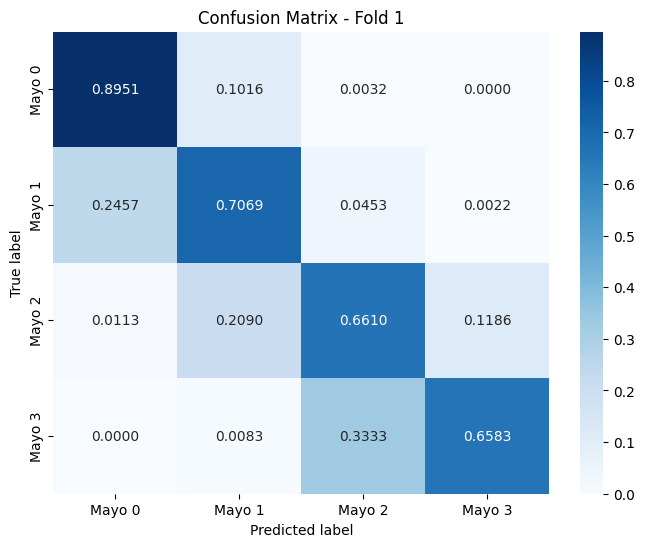

In [ ]:
# Set the fold index dynamically
fold_index = 0  # Change this to run different folds (0 for fold 1, 1 for fold 2, etc.)

# Get indices for the current fold
train_index, val_index = folds[fold_index]

train_files = filepaths[train_index]
train_labels = labels[train_index]
val_files = filepaths[val_index]
val_labels = labels[val_index]

# Create data generators for the current fold
train_generator, val_generator = create_generators(train_files, train_labels, val_files, val_labels)

print(f"Fold {fold_index + 1}")
print(f"Training: {len(train_files)} images")
print(f"Validation: {len(val_files)} images")

model = build_efficientnet_model(num_classes)

# Use the fold index in the checkpoint filename
checkpoint = ModelCheckpoint(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Training with class weights, early stopping, and learning rate scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_callback]
)

# Load the best weights for the current fold
model.load_weights(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5')

test_generator.reset()
test_preds = model.predict(test_generator)
test_y_true = test_generator.classes

# Calculate Top-1 Accuracy
test_y_pred_top1 = np.argmax(test_preds, axis=1)
fold_top1_accuracy = accuracy_score(test_y_true, test_y_pred_top1)

# Calculate Top-2 Accuracy
top2_pred = np.argsort(test_preds, axis=1)[:, -2:]
fold_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])

# Calculate QWK
fold_kappa = cohen_kappa_score(test_y_true, test_y_pred_top1, weights='quadratic')

fold_mae = mean_absolute_error(test_y_true, test_y_pred_top1)
fold_precision = precision_score(test_y_true, test_y_pred_top1, average='macro')
fold_recall = recall_score(test_y_true, test_y_pred_top1, average='macro')
fold_f1 = f1_score(test_y_true, test_y_pred_top1, average='macro')

accuracy_results.append(fold_top1_accuracy)
kappa_results.append(fold_kappa)
mae_results.append(fold_mae)
precision_results.append(fold_precision)
recall_results.append(fold_recall)
f1_results.append(fold_f1)

print(f"Fold {fold_index + 1} Top-1 Accuracy: {fold_top1_accuracy:.4f}")
print(f"Fold {fold_index + 1} Top-2 Accuracy: {fold_top2_accuracy:.4f}")
print(f"Fold {fold_index + 1} Quadratic Weighted Kappa: {fold_kappa:.4f}")
print(f"Fold {fold_index + 1} Mean Absolute Error: {fold_mae:.4f}")
print(f"Fold {fold_index + 1} Precision: {fold_precision:.4f}")
print(f"Fold {fold_index + 1} Recall: {fold_recall:.4f}")
print(f"Fold {fold_index + 1} F1 Score: {fold_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_y_true, test_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".4f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title=f'Confusion Matrix - Fold {fold_index + 1}')

# 2nd fold

Found 8631 validated image filenames belonging to 4 classes.
Found 959 validated image filenames belonging to 4 classes.
Fold 2
Training: 8631 images
Validation: 959 images
Epoch 1/30
540/540 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.6281

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


540/540 [==============================] - 583s 961ms/step - loss: 0.7393 - accuracy: 0.6281 - val_loss: 0.6266 - val_accuracy: 0.7414 - lr: 1.1000e-05
Epoch 2/30
540/540 [==============================] - 518s 959ms/step - loss: 0.6114 - accuracy: 0.7481 - val_loss: 0.5855 - val_accuracy: 0.7445 - lr: 1.2000e-05
Epoch 3/30
540/540 [==============================] - 518s 959ms/step - loss: 0.5738 - accuracy: 0.7594 - val_loss: 0.5596 - val_accuracy: 0.7810 - lr: 1.3000e-05
Epoch 4/30
540/540 [==============================] - 519s 959ms/step - loss: 0.5493 - accuracy: 0.7743 - val_loss: 0.5340 - val_accuracy: 0.7769 - lr: 1.4000e-05
Epoch 5/30
540/540 [==============================] - 518s 959ms/step - loss: 0.5187 - accuracy: 0.7846 - val_loss: 0.5188 - val_accuracy: 0.7685 - lr: 1.5000e-05
Epoch 6/30
540/540 [==============================] - 518s 959ms/step - loss: 0.4940 - accuracy: 0.7909 - val_loss: 0.4855 - val_accuracy: 0.7956 - lr: 1.2750e-05
Epoch 7/30
540/540 [=============

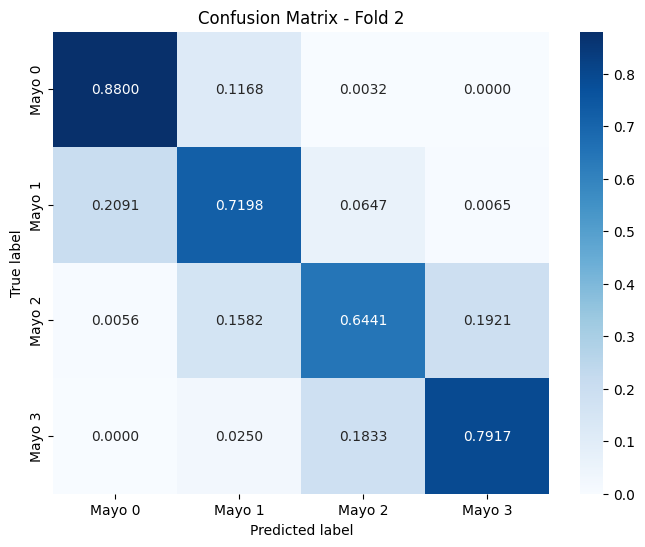

In [ ]:
# Set the fold index dynamically
fold_index = 1  # Change this to run different folds (0 for fold 1, 1 for fold 2, etc.)

# Get indices for the current fold
train_index, val_index = folds[fold_index]

train_files = filepaths[train_index]
train_labels = labels[train_index]
val_files = filepaths[val_index]
val_labels = labels[val_index]

# Create data generators for the current fold
train_generator, val_generator = create_generators(train_files, train_labels, val_files, val_labels)

print(f"Fold {fold_index + 1}")
print(f"Training: {len(train_files)} images")
print(f"Validation: {len(val_files)} images")

model = build_efficientnet_model(num_classes)

# Use the fold index in the checkpoint filename
checkpoint = ModelCheckpoint(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Training with class weights, early stopping, and learning rate scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_callback]
)

# Load the best weights for the current fold
model.load_weights(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5')

test_generator.reset()
test_preds = model.predict(test_generator)
test_y_true = test_generator.classes

# Calculate Top-1 Accuracy
test_y_pred_top1 = np.argmax(test_preds, axis=1)
fold_top1_accuracy = accuracy_score(test_y_true, test_y_pred_top1)

# Calculate Top-2 Accuracy
top2_pred = np.argsort(test_preds, axis=1)[:, -2:]
fold_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])

# Calculate QWK
fold_kappa = cohen_kappa_score(test_y_true, test_y_pred_top1, weights='quadratic')

fold_mae = mean_absolute_error(test_y_true, test_y_pred_top1)
fold_precision = precision_score(test_y_true, test_y_pred_top1, average='macro')
fold_recall = recall_score(test_y_true, test_y_pred_top1, average='macro')
fold_f1 = f1_score(test_y_true, test_y_pred_top1, average='macro')

accuracy_results.append(fold_top1_accuracy)
kappa_results.append(fold_kappa)
mae_results.append(fold_mae)
precision_results.append(fold_precision)
recall_results.append(fold_recall)
f1_results.append(fold_f1)

print(f"Fold {fold_index + 1} Top-1 Accuracy: {fold_top1_accuracy:.4f}")
print(f"Fold {fold_index + 1} Top-2 Accuracy: {fold_top2_accuracy:.4f}")
print(f"Fold {fold_index + 1} Quadratic Weighted Kappa: {fold_kappa:.4f}")
print(f"Fold {fold_index + 1} Mean Absolute Error: {fold_mae:.4f}")
print(f"Fold {fold_index + 1} Precision: {fold_precision:.4f}")
print(f"Fold {fold_index + 1} Recall: {fold_recall:.4f}")
print(f"Fold {fold_index + 1} F1 Score: {fold_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_y_true, test_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".4f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title=f'Confusion Matrix - Fold {fold_index + 1}')

# 3rd fold

Found 8631 validated image filenames belonging to 4 classes.
Found 959 validated image filenames belonging to 4 classes.
Fold 3
Training: 8631 images
Validation: 959 images
Epoch 1/30
540/540 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.6535

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


540/540 [==============================] - 581s 960ms/step - loss: 0.6914 - accuracy: 0.6535 - val_loss: 0.5934 - val_accuracy: 0.7320 - lr: 1.1000e-05
Epoch 2/30
540/540 [==============================] - 519s 960ms/step - loss: 0.5727 - accuracy: 0.7453 - val_loss: 0.5437 - val_accuracy: 0.7383 - lr: 1.2000e-05
Epoch 3/30
540/540 [==============================] - 518s 958ms/step - loss: 0.5288 - accuracy: 0.7623 - val_loss: 0.5140 - val_accuracy: 0.7477 - lr: 1.3000e-05
Epoch 4/30
540/540 [==============================] - 518s 958ms/step - loss: 0.4902 - accuracy: 0.7743 - val_loss: 0.4719 - val_accuracy: 0.7612 - lr: 1.4000e-05
Epoch 5/30
540/540 [==============================] - 519s 958ms/step - loss: 0.4536 - accuracy: 0.7792 - val_loss: 0.4499 - val_accuracy: 0.7560 - lr: 1.5000e-05
Epoch 6/30
540/540 [==============================] - 518s 958ms/step - loss: 0.4210 - accuracy: 0.7824 - val_loss: 0.4205 - val_accuracy: 0.7643 - lr: 1.2750e-05
Epoch 7/30
540/540 [=============

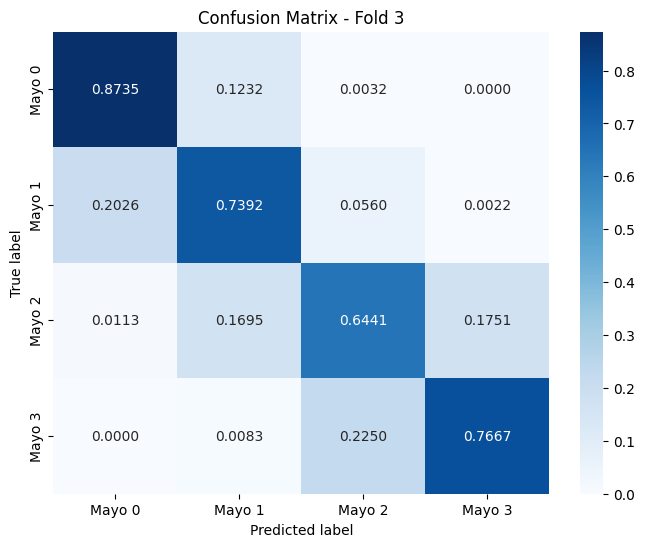

In [ ]:
# Set the fold index dynamically
fold_index = 2  # Change this to run different folds (0 for fold 1, 1 for fold 2, etc.)

# Get indices for the current fold
train_index, val_index = folds[fold_index]

train_files = filepaths[train_index]
train_labels = labels[train_index]
val_files = filepaths[val_index]
val_labels = labels[val_index]

# Create data generators for the current fold
train_generator, val_generator = create_generators(train_files, train_labels, val_files, val_labels)

print(f"Fold {fold_index + 1}")
print(f"Training: {len(train_files)} images")
print(f"Validation: {len(val_files)} images")

model = build_efficientnet_model(num_classes)

# Use the fold index in the checkpoint filename
checkpoint = ModelCheckpoint(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Training with class weights, early stopping, and learning rate scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_callback]
)

# Load the best weights for the current fold
model.load_weights(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5')

test_generator.reset()
test_preds = model.predict(test_generator)
test_y_true = test_generator.classes

# Calculate Top-1 Accuracy
test_y_pred_top1 = np.argmax(test_preds, axis=1)
fold_top1_accuracy = accuracy_score(test_y_true, test_y_pred_top1)

# Calculate Top-2 Accuracy
top2_pred = np.argsort(test_preds, axis=1)[:, -2:]
fold_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])

# Calculate QWK
fold_kappa = cohen_kappa_score(test_y_true, test_y_pred_top1, weights='quadratic')

fold_mae = mean_absolute_error(test_y_true, test_y_pred_top1)
fold_precision = precision_score(test_y_true, test_y_pred_top1, average='macro')
fold_recall = recall_score(test_y_true, test_y_pred_top1, average='macro')
fold_f1 = f1_score(test_y_true, test_y_pred_top1, average='macro')

accuracy_results.append(fold_top1_accuracy)
kappa_results.append(fold_kappa)
mae_results.append(fold_mae)
precision_results.append(fold_precision)
recall_results.append(fold_recall)
f1_results.append(fold_f1)

print(f"Fold {fold_index + 1} Top-1 Accuracy: {fold_top1_accuracy:.4f}")
print(f"Fold {fold_index + 1} Top-2 Accuracy: {fold_top2_accuracy:.4f}")
print(f"Fold {fold_index + 1} Quadratic Weighted Kappa: {fold_kappa:.4f}")
print(f"Fold {fold_index + 1} Mean Absolute Error: {fold_mae:.4f}")
print(f"Fold {fold_index + 1} Precision: {fold_precision:.4f}")
print(f"Fold {fold_index + 1} Recall: {fold_recall:.4f}")
print(f"Fold {fold_index + 1} F1 Score: {fold_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_y_true, test_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".4f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title=f'Confusion Matrix - Fold {fold_index + 1}')

# 4th fold

Found 8631 validated image filenames belonging to 4 classes.
Found 959 validated image filenames belonging to 4 classes.
Fold 4
Training: 8631 images
Validation: 959 images
71686520/71686520 [==============================] - 3s 0us/step
Epoch 1/30
540/540 [==============================] - ETA: 0s - loss: 0.7346 - accuracy: 0.6349 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


540/540 [==============================] - 8537s 16s/step - loss: 0.7346 - accuracy: 0.6349 - val_loss: 0.6122 - val_accuracy: 0.7424 - lr: 1.1000e-05
Epoch 2/30
540/540 [==============================] - 521s 964ms/step - loss: 0.6068 - accuracy: 0.7511 - val_loss: 0.5677 - val_accuracy: 0.7789 - lr: 1.2000e-05
Epoch 3/30
540/540 [==============================] - 523s 967ms/step - loss: 0.5679 - accuracy: 0.7643 - val_loss: 0.5530 - val_accuracy: 0.7800 - lr: 1.3000e-05
Epoch 4/30
540/540 [==============================] - 524s 969ms/step - loss: 0.5421 - accuracy: 0.7735 - val_loss: 0.5186 - val_accuracy: 0.7925 - lr: 1.4000e-05
Epoch 5/30
540/540 [==============================] - 523s 968ms/step - loss: 0.5093 - accuracy: 0.7887 - val_loss: 0.5092 - val_accuracy: 0.7550 - lr: 1.5000e-05
Epoch 6/30
540/540 [==============================] - 523s 967ms/step - loss: 0.4859 - accuracy: 0.7868 - val_loss: 0.4832 - val_accuracy: 0.7623 - lr: 1.2750e-05
Epoch 7/30
540/540 [==============

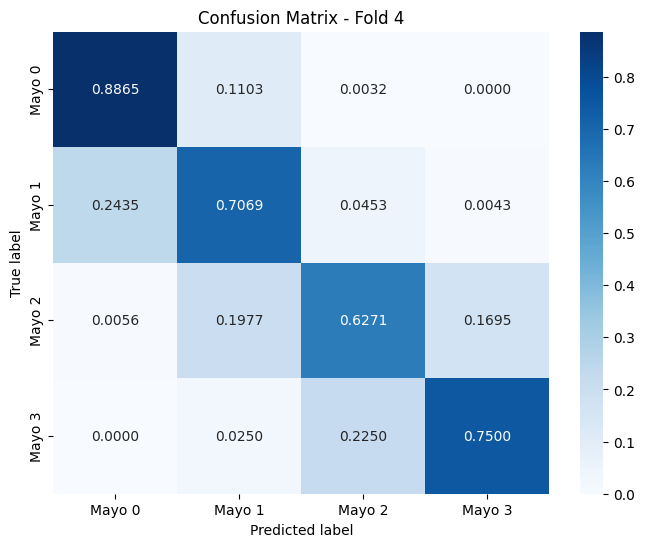

In [ ]:
# Set the fold index dynamically
fold_index = 3  # Change this to run different folds (0 for fold 1, 1 for fold 2, etc.)

# Get indices for the current fold
train_index, val_index = folds[fold_index]

train_files = filepaths[train_index]
train_labels = labels[train_index]
val_files = filepaths[val_index]
val_labels = labels[val_index]

# Create data generators for the current fold
train_generator, val_generator = create_generators(train_files, train_labels, val_files, val_labels)

print(f"Fold {fold_index + 1}")
print(f"Training: {len(train_files)} images")
print(f"Validation: {len(val_files)} images")

model = build_efficientnet_model(num_classes)

# Use the fold index in the checkpoint filename
checkpoint = ModelCheckpoint(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Training with class weights, early stopping, and learning rate scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_callback]
)

# Load the best weights for the current fold
model.load_weights(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5')

test_generator.reset()
test_preds = model.predict(test_generator)
test_y_true = test_generator.classes

# Calculate Top-1 Accuracy
test_y_pred_top1 = np.argmax(test_preds, axis=1)
fold_top1_accuracy = accuracy_score(test_y_true, test_y_pred_top1)

# Calculate Top-2 Accuracy
top2_pred = np.argsort(test_preds, axis=1)[:, -2:]
fold_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])

# Calculate QWK
fold_kappa = cohen_kappa_score(test_y_true, test_y_pred_top1, weights='quadratic')

fold_mae = mean_absolute_error(test_y_true, test_y_pred_top1)
fold_precision = precision_score(test_y_true, test_y_pred_top1, average='macro')
fold_recall = recall_score(test_y_true, test_y_pred_top1, average='macro')
fold_f1 = f1_score(test_y_true, test_y_pred_top1, average='macro')

accuracy_results.append(fold_top1_accuracy)
kappa_results.append(fold_kappa)
mae_results.append(fold_mae)
precision_results.append(fold_precision)
recall_results.append(fold_recall)
f1_results.append(fold_f1)

print(f"Fold {fold_index + 1} Top-1 Accuracy: {fold_top1_accuracy:.4f}")
print(f"Fold {fold_index + 1} Top-2 Accuracy: {fold_top2_accuracy:.4f}")
print(f"Fold {fold_index + 1} Quadratic Weighted Kappa: {fold_kappa:.4f}")
print(f"Fold {fold_index + 1} Mean Absolute Error: {fold_mae:.4f}")
print(f"Fold {fold_index + 1} Precision: {fold_precision:.4f}")
print(f"Fold {fold_index + 1} Recall: {fold_recall:.4f}")
print(f"Fold {fold_index + 1} F1 Score: {fold_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_y_true, test_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".4f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title=f'Confusion Matrix - Fold {fold_index + 1}')

# 5th fold

Found 8631 validated image filenames belonging to 4 classes.
Found 959 validated image filenames belonging to 4 classes.
Fold 5
Training: 8631 images
Validation: 959 images
Epoch 1/30
540/540 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.6285

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


540/540 [==============================] - 616s 1s/step - loss: 0.7409 - accuracy: 0.6285 - val_loss: 0.6409 - val_accuracy: 0.7143 - lr: 1.1000e-05
Epoch 2/30
540/540 [==============================] - 523s 968ms/step - loss: 0.6096 - accuracy: 0.7515 - val_loss: 0.5980 - val_accuracy: 0.7477 - lr: 1.2000e-05
Epoch 3/30
540/540 [==============================] - 523s 968ms/step - loss: 0.5736 - accuracy: 0.7649 - val_loss: 0.5697 - val_accuracy: 0.7477 - lr: 1.3000e-05
Epoch 4/30
540/540 [==============================] - 524s 970ms/step - loss: 0.5471 - accuracy: 0.7764 - val_loss: 0.5408 - val_accuracy: 0.7466 - lr: 1.4000e-05
Epoch 5/30
540/540 [==============================] - 523s 968ms/step - loss: 0.5167 - accuracy: 0.7857 - val_loss: 0.5116 - val_accuracy: 0.7758 - lr: 1.5000e-05
Epoch 6/30
540/540 [==============================] - 523s 967ms/step - loss: 0.4936 - accuracy: 0.7953 - val_loss: 0.4997 - val_accuracy: 0.7477 - lr: 1.2750e-05
Epoch 7/30
540/540 [================

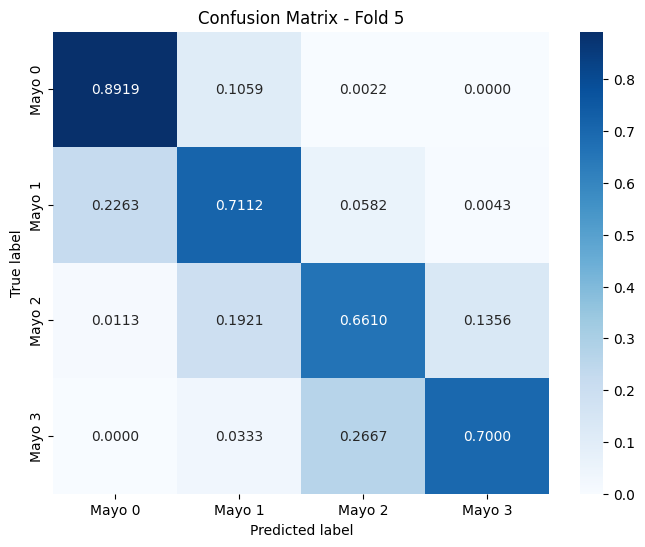

In [ ]:
# Set the fold index dynamically
fold_index = 4  # Change this to run different folds (0 for fold 1, 1 for fold 2, etc.)

# Get indices for the current fold
train_index, val_index = folds[fold_index]

train_files = filepaths[train_index]
train_labels = labels[train_index]
val_files = filepaths[val_index]
val_labels = labels[val_index]

# Create data generators for the current fold
train_generator, val_generator = create_generators(train_files, train_labels, val_files, val_labels)

print(f"Fold {fold_index + 1}")
print(f"Training: {len(train_files)} images")
print(f"Validation: {len(val_files)} images")

model = build_efficientnet_model(num_classes)

# Use the fold index in the checkpoint filename
checkpoint = ModelCheckpoint(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Training with class weights, early stopping, and learning rate scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_callback]
)

# Load the best weights for the current fold
model.load_weights(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5')

test_generator.reset()
test_preds = model.predict(test_generator)
test_y_true = test_generator.classes

# Calculate Top-1 Accuracy
test_y_pred_top1 = np.argmax(test_preds, axis=1)
fold_top1_accuracy = accuracy_score(test_y_true, test_y_pred_top1)

# Calculate Top-2 Accuracy
top2_pred = np.argsort(test_preds, axis=1)[:, -2:]
fold_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])

# Calculate QWK
fold_kappa = cohen_kappa_score(test_y_true, test_y_pred_top1, weights='quadratic')

fold_mae = mean_absolute_error(test_y_true, test_y_pred_top1)
fold_precision = precision_score(test_y_true, test_y_pred_top1, average='macro')
fold_recall = recall_score(test_y_true, test_y_pred_top1, average='macro')
fold_f1 = f1_score(test_y_true, test_y_pred_top1, average='macro')

accuracy_results.append(fold_top1_accuracy)
kappa_results.append(fold_kappa)
mae_results.append(fold_mae)
precision_results.append(fold_precision)
recall_results.append(fold_recall)
f1_results.append(fold_f1)

print(f"Fold {fold_index + 1} Top-1 Accuracy: {fold_top1_accuracy:.4f}")
print(f"Fold {fold_index + 1} Top-2 Accuracy: {fold_top2_accuracy:.4f}")
print(f"Fold {fold_index + 1} Quadratic Weighted Kappa: {fold_kappa:.4f}")
print(f"Fold {fold_index + 1} Mean Absolute Error: {fold_mae:.4f}")
print(f"Fold {fold_index + 1} Precision: {fold_precision:.4f}")
print(f"Fold {fold_index + 1} Recall: {fold_recall:.4f}")
print(f"Fold {fold_index + 1} F1 Score: {fold_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_y_true, test_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".4f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title=f'Confusion Matrix - Fold {fold_index + 1}')

# 6th fold

Found 8631 validated image filenames belonging to 4 classes.
Found 959 validated image filenames belonging to 4 classes.
Fold 6
Training: 8631 images
Validation: 959 images
Epoch 1/30
540/540 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.6582

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


540/540 [==============================] - 608s 1s/step - loss: 0.6910 - accuracy: 0.6582 - val_loss: 0.5921 - val_accuracy: 0.7205 - lr: 1.1000e-05
Epoch 2/30
540/540 [==============================] - 523s 966ms/step - loss: 0.5721 - accuracy: 0.7435 - val_loss: 0.5407 - val_accuracy: 0.7466 - lr: 1.2000e-05
Epoch 3/30
540/540 [==============================] - 522s 966ms/step - loss: 0.5247 - accuracy: 0.7655 - val_loss: 0.5183 - val_accuracy: 0.7320 - lr: 1.3000e-05
Epoch 4/30
540/540 [==============================] - 523s 966ms/step - loss: 0.4896 - accuracy: 0.7714 - val_loss: 0.4887 - val_accuracy: 0.7508 - lr: 1.4000e-05
Epoch 5/30
540/540 [==============================] - 521s 965ms/step - loss: 0.4504 - accuracy: 0.7859 - val_loss: 0.4323 - val_accuracy: 0.7716 - lr: 1.5000e-05
Epoch 6/30
540/540 [==============================] - 521s 964ms/step - loss: 0.4182 - accuracy: 0.7933 - val_loss: 0.4079 - val_accuracy: 0.7696 - lr: 1.2750e-05
Epoch 7/30
540/540 [================

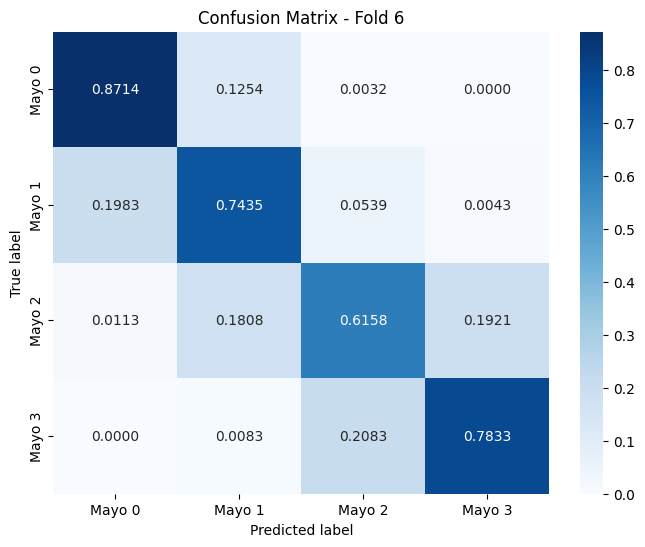

In [ ]:
# Set the fold index dynamically
fold_index = 5  # Change this to run different folds (0 for fold 1, 1 for fold 2, etc.)

# Get indices for the current fold
train_index, val_index = folds[fold_index]

train_files = filepaths[train_index]
train_labels = labels[train_index]
val_files = filepaths[val_index]
val_labels = labels[val_index]

# Create data generators for the current fold
train_generator, val_generator = create_generators(train_files, train_labels, val_files, val_labels)

print(f"Fold {fold_index + 1}")
print(f"Training: {len(train_files)} images")
print(f"Validation: {len(val_files)} images")

model = build_efficientnet_model(num_classes)

# Use the fold index in the checkpoint filename
checkpoint = ModelCheckpoint(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Training with class weights, early stopping, and learning rate scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_callback]
)

# Load the best weights for the current fold
model.load_weights(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5')

test_generator.reset()
test_preds = model.predict(test_generator)
test_y_true = test_generator.classes

# Calculate Top-1 Accuracy
test_y_pred_top1 = np.argmax(test_preds, axis=1)
fold_top1_accuracy = accuracy_score(test_y_true, test_y_pred_top1)

# Calculate Top-2 Accuracy
top2_pred = np.argsort(test_preds, axis=1)[:, -2:]
fold_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])

# Calculate QWK
fold_kappa = cohen_kappa_score(test_y_true, test_y_pred_top1, weights='quadratic')

fold_mae = mean_absolute_error(test_y_true, test_y_pred_top1)
fold_precision = precision_score(test_y_true, test_y_pred_top1, average='macro')
fold_recall = recall_score(test_y_true, test_y_pred_top1, average='macro')
fold_f1 = f1_score(test_y_true, test_y_pred_top1, average='macro')

accuracy_results.append(fold_top1_accuracy)
kappa_results.append(fold_kappa)
mae_results.append(fold_mae)
precision_results.append(fold_precision)
recall_results.append(fold_recall)
f1_results.append(fold_f1)

print(f"Fold {fold_index + 1} Top-1 Accuracy: {fold_top1_accuracy:.4f}")
print(f"Fold {fold_index + 1} Top-2 Accuracy: {fold_top2_accuracy:.4f}")
print(f"Fold {fold_index + 1} Quadratic Weighted Kappa: {fold_kappa:.4f}")
print(f"Fold {fold_index + 1} Mean Absolute Error: {fold_mae:.4f}")
print(f"Fold {fold_index + 1} Precision: {fold_precision:.4f}")
print(f"Fold {fold_index + 1} Recall: {fold_recall:.4f}")
print(f"Fold {fold_index + 1} F1 Score: {fold_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_y_true, test_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".4f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title=f'Confusion Matrix - Fold {fold_index + 1}')

# 7th fold

Found 8631 validated image filenames belonging to 4 classes.
Found 959 validated image filenames belonging to 4 classes.
Fold 7
Training: 8631 images
Validation: 959 images
71686520/71686520 [==============================] - 4s 0us/step
Epoch 1/30
540/540 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.6235 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


540/540 [==============================] - 9195s 17s/step - loss: 0.7404 - accuracy: 0.6235 - val_loss: 0.6104 - val_accuracy: 0.7435 - lr: 1.1000e-05
Epoch 2/30
540/540 [==============================] - 519s 960ms/step - loss: 0.6093 - accuracy: 0.7428 - val_loss: 0.5661 - val_accuracy: 0.7748 - lr: 1.2000e-05
Epoch 3/30
540/540 [==============================] - 520s 962ms/step - loss: 0.5710 - accuracy: 0.7633 - val_loss: 0.5455 - val_accuracy: 0.7727 - lr: 1.3000e-05
Epoch 4/30
540/540 [==============================] - 519s 960ms/step - loss: 0.5434 - accuracy: 0.7752 - val_loss: 0.5193 - val_accuracy: 0.7779 - lr: 1.4000e-05
Epoch 5/30
540/540 [==============================] - 520s 960ms/step - loss: 0.5094 - accuracy: 0.7853 - val_loss: 0.4856 - val_accuracy: 0.7914 - lr: 1.5000e-05
Epoch 6/30
540/540 [==============================] - 519s 959ms/step - loss: 0.4859 - accuracy: 0.7872 - val_loss: 0.4667 - val_accuracy: 0.7998 - lr: 1.2750e-05
Epoch 7/30
540/540 [==============

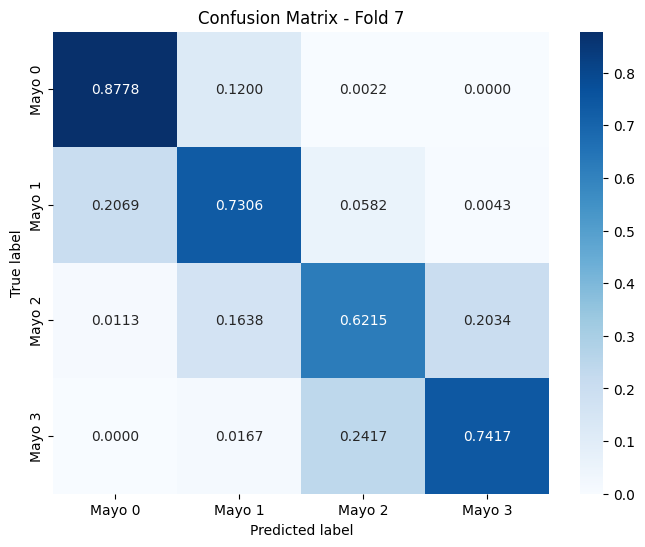

In [ ]:
# Set the fold index dynamically
fold_index = 6  # Change this to run different folds (0 for fold 1, 1 for fold 2, etc.)

# Get indices for the current fold
train_index, val_index = folds[fold_index]

train_files = filepaths[train_index]
train_labels = labels[train_index]
val_files = filepaths[val_index]
val_labels = labels[val_index]

# Create data generators for the current fold
train_generator, val_generator = create_generators(train_files, train_labels, val_files, val_labels)

print(f"Fold {fold_index + 1}")
print(f"Training: {len(train_files)} images")
print(f"Validation: {len(val_files)} images")

model = build_efficientnet_model(num_classes)

# Use the fold index in the checkpoint filename
checkpoint = ModelCheckpoint(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Training with class weights, early stopping, and learning rate scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_callback]
)

# Load the best weights for the current fold
model.load_weights(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5')

test_generator.reset()
test_preds = model.predict(test_generator)
test_y_true = test_generator.classes

# Calculate Top-1 Accuracy
test_y_pred_top1 = np.argmax(test_preds, axis=1)
fold_top1_accuracy = accuracy_score(test_y_true, test_y_pred_top1)

# Calculate Top-2 Accuracy
top2_pred = np.argsort(test_preds, axis=1)[:, -2:]
fold_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])

# Calculate QWK
fold_kappa = cohen_kappa_score(test_y_true, test_y_pred_top1, weights='quadratic')

fold_mae = mean_absolute_error(test_y_true, test_y_pred_top1)
fold_precision = precision_score(test_y_true, test_y_pred_top1, average='macro')
fold_recall = recall_score(test_y_true, test_y_pred_top1, average='macro')
fold_f1 = f1_score(test_y_true, test_y_pred_top1, average='macro')

accuracy_results.append(fold_top1_accuracy)
kappa_results.append(fold_kappa)
mae_results.append(fold_mae)
precision_results.append(fold_precision)
recall_results.append(fold_recall)
f1_results.append(fold_f1)

print(f"Fold {fold_index + 1} Top-1 Accuracy: {fold_top1_accuracy:.4f}")
print(f"Fold {fold_index + 1} Top-2 Accuracy: {fold_top2_accuracy:.4f}")
print(f"Fold {fold_index + 1} Quadratic Weighted Kappa: {fold_kappa:.4f}")
print(f"Fold {fold_index + 1} Mean Absolute Error: {fold_mae:.4f}")
print(f"Fold {fold_index + 1} Precision: {fold_precision:.4f}")
print(f"Fold {fold_index + 1} Recall: {fold_recall:.4f}")
print(f"Fold {fold_index + 1} F1 Score: {fold_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_y_true, test_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".4f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title=f'Confusion Matrix - Fold {fold_index + 1}')

# 8th fold

Found 8631 validated image filenames belonging to 4 classes.
Found 959 validated image filenames belonging to 4 classes.
Fold 8
Training: 8631 images
Validation: 959 images
Epoch 1/30
540/540 [==============================] - ETA: 0s - loss: 0.7392 - accuracy: 0.6311

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


540/540 [==============================] - 596s 989ms/step - loss: 0.7392 - accuracy: 0.6311 - val_loss: 0.6143 - val_accuracy: 0.7550 - lr: 1.1000e-05
Epoch 2/30
540/540 [==============================] - 518s 958ms/step - loss: 0.6079 - accuracy: 0.7459 - val_loss: 0.5828 - val_accuracy: 0.7696 - lr: 1.2000e-05
Epoch 3/30
540/540 [==============================] - 518s 958ms/step - loss: 0.5723 - accuracy: 0.7669 - val_loss: 0.5612 - val_accuracy: 0.7716 - lr: 1.3000e-05
Epoch 4/30
540/540 [==============================] - 518s 958ms/step - loss: 0.5489 - accuracy: 0.7743 - val_loss: 0.5379 - val_accuracy: 0.7612 - lr: 1.4000e-05
Epoch 5/30
540/540 [==============================] - 518s 957ms/step - loss: 0.5160 - accuracy: 0.7842 - val_loss: 0.5135 - val_accuracy: 0.7800 - lr: 1.5000e-05
Epoch 6/30
540/540 [==============================] - 517s 957ms/step - loss: 0.4932 - accuracy: 0.7927 - val_loss: 0.4925 - val_accuracy: 0.7862 - lr: 1.2750e-05
Epoch 7/30
540/540 [=============

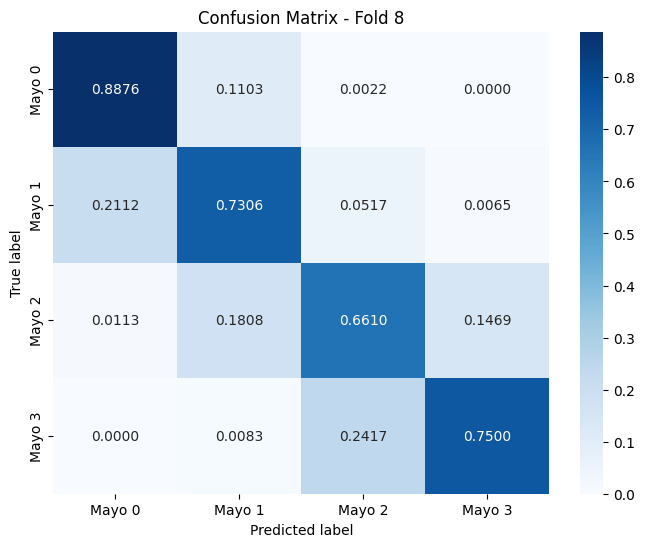

In [ ]:
# Set the fold index dynamically
fold_index = 7  # Change this to run different folds (0 for fold 1, 1 for fold 2, etc.)

# Get indices for the current fold
train_index, val_index = folds[fold_index]

train_files = filepaths[train_index]
train_labels = labels[train_index]
val_files = filepaths[val_index]
val_labels = labels[val_index]

# Create data generators for the current fold
train_generator, val_generator = create_generators(train_files, train_labels, val_files, val_labels)

print(f"Fold {fold_index + 1}")
print(f"Training: {len(train_files)} images")
print(f"Validation: {len(val_files)} images")

model = build_efficientnet_model(num_classes)

# Use the fold index in the checkpoint filename
checkpoint = ModelCheckpoint(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Training with class weights, early stopping, and learning rate scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_callback]
)

# Load the best weights for the current fold
model.load_weights(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5')

test_generator.reset()
test_preds = model.predict(test_generator)
test_y_true = test_generator.classes

# Calculate Top-1 Accuracy
test_y_pred_top1 = np.argmax(test_preds, axis=1)
fold_top1_accuracy = accuracy_score(test_y_true, test_y_pred_top1)

# Calculate Top-2 Accuracy
top2_pred = np.argsort(test_preds, axis=1)[:, -2:]
fold_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])

# Calculate QWK
fold_kappa = cohen_kappa_score(test_y_true, test_y_pred_top1, weights='quadratic')

fold_mae = mean_absolute_error(test_y_true, test_y_pred_top1)
fold_precision = precision_score(test_y_true, test_y_pred_top1, average='macro')
fold_recall = recall_score(test_y_true, test_y_pred_top1, average='macro')
fold_f1 = f1_score(test_y_true, test_y_pred_top1, average='macro')

accuracy_results.append(fold_top1_accuracy)
kappa_results.append(fold_kappa)
mae_results.append(fold_mae)
precision_results.append(fold_precision)
recall_results.append(fold_recall)
f1_results.append(fold_f1)

print(f"Fold {fold_index + 1} Top-1 Accuracy: {fold_top1_accuracy:.4f}")
print(f"Fold {fold_index + 1} Top-2 Accuracy: {fold_top2_accuracy:.4f}")
print(f"Fold {fold_index + 1} Quadratic Weighted Kappa: {fold_kappa:.4f}")
print(f"Fold {fold_index + 1} Mean Absolute Error: {fold_mae:.4f}")
print(f"Fold {fold_index + 1} Precision: {fold_precision:.4f}")
print(f"Fold {fold_index + 1} Recall: {fold_recall:.4f}")
print(f"Fold {fold_index + 1} F1 Score: {fold_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_y_true, test_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".4f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title=f'Confusion Matrix - Fold {fold_index + 1}')

# 9th fold

Found 8631 validated image filenames belonging to 4 classes.
Found 959 validated image filenames belonging to 4 classes.
Fold 9
Training: 8631 images
Validation: 959 images
Epoch 1/30
540/540 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.6510

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


540/540 [==============================] - 584s 963ms/step - loss: 0.6938 - accuracy: 0.6510 - val_loss: 0.5812 - val_accuracy: 0.7424 - lr: 1.1000e-05
Epoch 2/30
540/540 [==============================] - 520s 962ms/step - loss: 0.5774 - accuracy: 0.7402 - val_loss: 0.5435 - val_accuracy: 0.7602 - lr: 1.2000e-05
Epoch 3/30
540/540 [==============================] - 520s 961ms/step - loss: 0.5317 - accuracy: 0.7585 - val_loss: 0.4963 - val_accuracy: 0.7935 - lr: 1.3000e-05
Epoch 4/30
540/540 [==============================] - 518s 959ms/step - loss: 0.4966 - accuracy: 0.7629 - val_loss: 0.4642 - val_accuracy: 0.7727 - lr: 1.4000e-05
Epoch 5/30
540/540 [==============================] - 519s 961ms/step - loss: 0.4551 - accuracy: 0.7804 - val_loss: 0.4374 - val_accuracy: 0.7779 - lr: 1.5000e-05
Epoch 6/30
540/540 [==============================] - 521s 962ms/step - loss: 0.4225 - accuracy: 0.7883 - val_loss: 0.4126 - val_accuracy: 0.7883 - lr: 1.2750e-05
Epoch 7/30
540/540 [=============

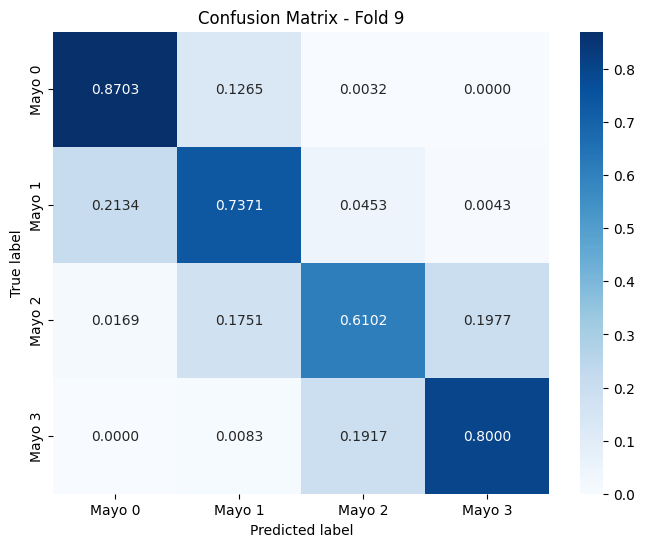

In [ ]:
# Set the fold index dynamically
fold_index = 8  # Change this to run different folds (0 for fold 1, 1 for fold 2, etc.)

# Get indices for the current fold
train_index, val_index = folds[fold_index]

train_files = filepaths[train_index]
train_labels = labels[train_index]
val_files = filepaths[val_index]
val_labels = labels[val_index]

# Create data generators for the current fold
train_generator, val_generator = create_generators(train_files, train_labels, val_files, val_labels)

print(f"Fold {fold_index + 1}")
print(f"Training: {len(train_files)} images")
print(f"Validation: {len(val_files)} images")

model = build_efficientnet_model(num_classes)

# Use the fold index in the checkpoint filename
checkpoint = ModelCheckpoint(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Training with class weights, early stopping, and learning rate scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_callback]
)

# Load the best weights for the current fold
model.load_weights(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5')

test_generator.reset()
test_preds = model.predict(test_generator)
test_y_true = test_generator.classes

# Calculate Top-1 Accuracy
test_y_pred_top1 = np.argmax(test_preds, axis=1)
fold_top1_accuracy = accuracy_score(test_y_true, test_y_pred_top1)

# Calculate Top-2 Accuracy
top2_pred = np.argsort(test_preds, axis=1)[:, -2:]
fold_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])

# Calculate QWK
fold_kappa = cohen_kappa_score(test_y_true, test_y_pred_top1, weights='quadratic')

fold_mae = mean_absolute_error(test_y_true, test_y_pred_top1)
fold_precision = precision_score(test_y_true, test_y_pred_top1, average='macro')
fold_recall = recall_score(test_y_true, test_y_pred_top1, average='macro')
fold_f1 = f1_score(test_y_true, test_y_pred_top1, average='macro')

accuracy_results.append(fold_top1_accuracy)
kappa_results.append(fold_kappa)
mae_results.append(fold_mae)
precision_results.append(fold_precision)
recall_results.append(fold_recall)
f1_results.append(fold_f1)

print(f"Fold {fold_index + 1} Top-1 Accuracy: {fold_top1_accuracy:.4f}")
print(f"Fold {fold_index + 1} Top-2 Accuracy: {fold_top2_accuracy:.4f}")
print(f"Fold {fold_index + 1} Quadratic Weighted Kappa: {fold_kappa:.4f}")
print(f"Fold {fold_index + 1} Mean Absolute Error: {fold_mae:.4f}")
print(f"Fold {fold_index + 1} Precision: {fold_precision:.4f}")
print(f"Fold {fold_index + 1} Recall: {fold_recall:.4f}")
print(f"Fold {fold_index + 1} F1 Score: {fold_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_y_true, test_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".4f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title=f'Confusion Matrix - Fold {fold_index + 1}')

# 10th fold

Found 8631 validated image filenames belonging to 4 classes.
Found 959 validated image filenames belonging to 4 classes.
Fold 10
Training: 8631 images
Validation: 959 images
71686520/71686520 [==============================] - 3s 0us/step
Epoch 1/30
540/540 [==============================] - ETA: 0s - loss: 0.7354 - accuracy: 0.6306 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


540/540 [==============================] - 8639s 16s/step - loss: 0.7354 - accuracy: 0.6306 - val_loss: 0.6129 - val_accuracy: 0.7518 - lr: 1.1000e-05
Epoch 2/30
540/540 [==============================] - 523s 968ms/step - loss: 0.6074 - accuracy: 0.7436 - val_loss: 0.5703 - val_accuracy: 0.7810 - lr: 1.2000e-05
Epoch 3/30
540/540 [==============================] - 522s 966ms/step - loss: 0.5675 - accuracy: 0.7624 - val_loss: 0.5582 - val_accuracy: 0.7508 - lr: 1.3000e-05
Epoch 4/30
540/540 [==============================] - 522s 965ms/step - loss: 0.5411 - accuracy: 0.7720 - val_loss: 0.5187 - val_accuracy: 0.7946 - lr: 1.4000e-05
Epoch 5/30
540/540 [==============================] - 524s 969ms/step - loss: 0.5091 - accuracy: 0.7860 - val_loss: 0.4965 - val_accuracy: 0.7852 - lr: 1.5000e-05
Epoch 6/30
540/540 [==============================] - 521s 964ms/step - loss: 0.4840 - accuracy: 0.7939 - val_loss: 0.4832 - val_accuracy: 0.7789 - lr: 1.2750e-05
Epoch 7/30
540/540 [==============

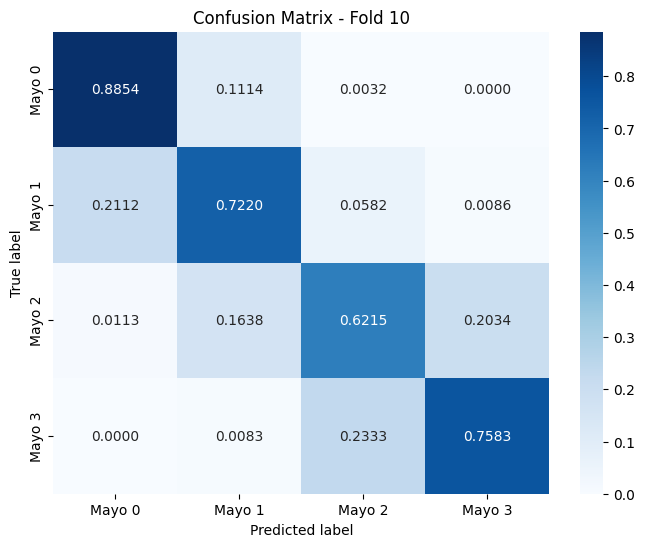

In [ ]:
# Set the fold index dynamically
fold_index = 9  # Change this to run different folds (0 for fold 1, 1 for fold 2, etc.)

# Get indices for the current fold
train_index, val_index = folds[fold_index]

train_files = filepaths[train_index]
train_labels = labels[train_index]
val_files = filepaths[val_index]
val_labels = labels[val_index]

# Create data generators for the current fold
train_generator, val_generator = create_generators(train_files, train_labels, val_files, val_labels)

print(f"Fold {fold_index + 1}")
print(f"Training: {len(train_files)} images")
print(f"Validation: {len(val_files)} images")

model = build_efficientnet_model(num_classes)

# Use the fold index in the checkpoint filename
checkpoint = ModelCheckpoint(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Training with class weights, early stopping, and learning rate scheduler
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_callback]
)

# Load the best weights for the current fold
model.load_weights(f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{fold_index + 1}.h5')

test_generator.reset()
test_preds = model.predict(test_generator)
test_y_true = test_generator.classes

# Calculate Top-1 Accuracy
test_y_pred_top1 = np.argmax(test_preds, axis=1)
fold_top1_accuracy = accuracy_score(test_y_true, test_y_pred_top1)

# Calculate Top-2 Accuracy
top2_pred = np.argsort(test_preds, axis=1)[:, -2:]
fold_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])

# Calculate QWK
fold_kappa = cohen_kappa_score(test_y_true, test_y_pred_top1, weights='quadratic')

fold_mae = mean_absolute_error(test_y_true, test_y_pred_top1)
fold_precision = precision_score(test_y_true, test_y_pred_top1, average='macro')
fold_recall = recall_score(test_y_true, test_y_pred_top1, average='macro')
fold_f1 = f1_score(test_y_true, test_y_pred_top1, average='macro')

accuracy_results.append(fold_top1_accuracy)
kappa_results.append(fold_kappa)
mae_results.append(fold_mae)
precision_results.append(fold_precision)
recall_results.append(fold_recall)
f1_results.append(fold_f1)

print(f"Fold {fold_index + 1} Top-1 Accuracy: {fold_top1_accuracy:.4f}")
print(f"Fold {fold_index + 1} Top-2 Accuracy: {fold_top2_accuracy:.4f}")
print(f"Fold {fold_index + 1} Quadratic Weighted Kappa: {fold_kappa:.4f}")
print(f"Fold {fold_index + 1} Mean Absolute Error: {fold_mae:.4f}")
print(f"Fold {fold_index + 1} Precision: {fold_precision:.4f}")
print(f"Fold {fold_index + 1} Recall: {fold_recall:.4f}")
print(f"Fold {fold_index + 1} F1 Score: {fold_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_y_true, test_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".4f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title=f'Confusion Matrix - Fold {fold_index + 1}')

# Ensemble learning

Mounted at /content/drive
Found 1686 images belonging to 4 classes.
Ensemble class weights saved at: /content/drive/My Drive/LIMUC/ensemble_class_weights.json
106/106 [==============================] - 24s 202ms/step
Ensemble predictions saved at: /content/drive/My Drive/LIMUC/ensemble_predictions.npy
Ensemble Top-1 Accuracy: 0.8120
Ensemble Top-2 Accuracy: 0.9822
Ensemble Quadratic Weighted Kappa: 0.8810
Ensemble Mean Absolute Error: 0.1928
Ensemble Precision: 0.7586
Ensemble Recall: 0.7609
Ensemble F1 Score: 0.7596


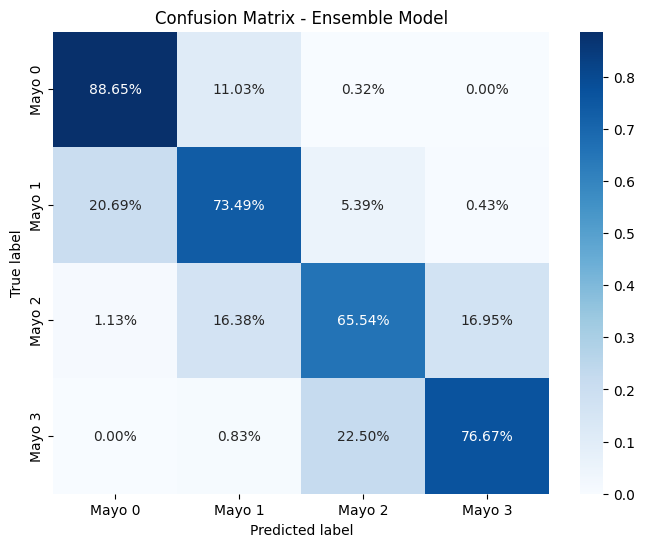

Grouped Top-1 Accuracy: 0.9632
Grouped Top-2 Accuracy: 0.8790
Grouped Kappa: 0.8730
Grouped Mean Absolute Error: 0.0368
Grouped Precision: 0.9377
Grouped Recall: 0.9353
Grouped F1 Score: 0.9365


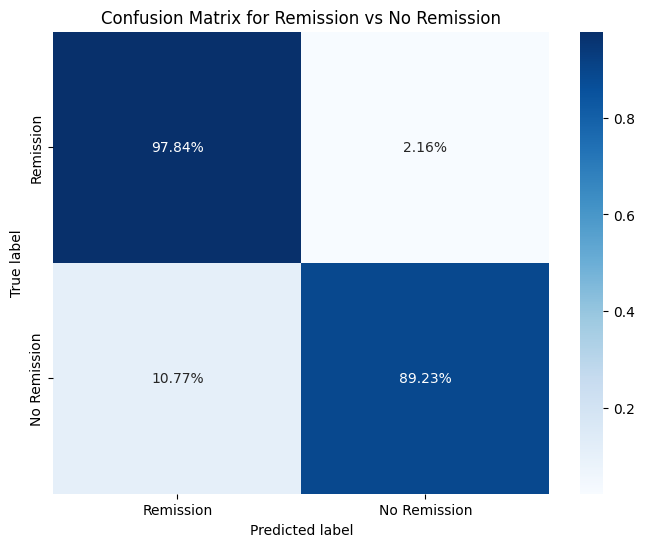

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Layer, Multiply, Reshape, Conv2D
from tensorflow.keras.utils import get_custom_objects
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_absolute_error, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Define the combined focal loss with confidence penalty as a standalone function
def combined_focal_confidence_penalty_loss(y_true, y_pred, gamma=2.0, alpha=0.5, lambda_cp=0.01, smoothing=0.1):
    y_true = y_true * (1 - smoothing) + smoothing / num_classes  # Label Smoothing
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    pt = tf.reduce_sum(y_true * y_pred, axis=-1)
    focal_weight = alpha * tf.pow(1 - pt, gamma)
    focal_loss = focal_weight * ce_loss

    # Confidence Penalty
    entropy = - (y_pred * tf.math.log(y_pred))
    confidence_penalty = lambda_cp * tf.reduce_sum(entropy, axis=-1)

    total_loss = tf.reduce_mean(focal_loss + confidence_penalty)
    return total_loss

# Register the custom loss function and layers globally
get_custom_objects()['combined_focal_confidence_penalty_loss'] = combined_focal_confidence_penalty_loss

# Define the Squeeze-and-Excitation Layer
class SqueezeExcitationLayer(Layer):
    def __init__(self, output_dim, ratio=16):
        super(SqueezeExcitationLayer, self).__init__()
        self.global_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(output_dim // ratio, activation='swish')
        self.dense2 = Dense(output_dim, activation='sigmoid')
        self.reshape = Reshape((1, 1, output_dim))
        self.multiply = Multiply()

    def call(self, inputs):
        x = self.global_pool(inputs)
        x = self.reshape(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.multiply([inputs, x])

# Define the Spatial Attention Layer
class SpatialAttentionLayer(Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttentionLayer, self).__init__()
        self.conv1 = Conv2D(1, kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        return self.conv1(concat) * inputs

# Register the custom layers globally
get_custom_objects()['SqueezeExcitationLayer'] = SqueezeExcitationLayer
get_custom_objects()['SpatialAttentionLayer'] = SpatialAttentionLayer

# Set number of classes
class_names = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
num_classes = len(class_names)

# Path to the test set
test_path = '/content/drive/My Drive/LIMUC/test_set'

# Define the test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Load test data using the generator
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(380, 380),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Define paths to each saved model from the 10 folds
model_paths = [f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{i + 1}.h5' for i in range(10)]

# Load the models without needing the original loss, then recompile with the custom loss
models = []
for path in model_paths:
    model = load_model(path, compile=False)
    model.compile(optimizer='adam', loss=combined_focal_confidence_penalty_loss, metrics=['accuracy'])
    models.append(model)

# Compute class-specific weights for each fold (use integer keys)
class_weights_per_model = {
    c: [1.0 / model.evaluate(test_generator, verbose=0)[0] for model in models]  # Inverse loss
    for c in range(num_classes)
}

# Save the ensemble class weights for future use
weights_save_path = '/content/drive/My Drive/LIMUC/ensemble_class_weights.json'
with open(weights_save_path, 'w') as f:
    json.dump({int(k): v for k, v in class_weights_per_model.items()}, f)  # Save keys as integers

print(f"Ensemble class weights saved at: {weights_save_path}")

# Class-Specific Weighted Averaging Function
def class_specific_weighted_ensemble_predict(models, class_weights_per_model, test_generator):
    final_predictions = []

    for i, model in enumerate(models):
        model_preds = model.predict(test_generator, verbose=1)

        # Apply class-specific weights for the current model
        class_weights = np.array([class_weights_per_model[c][i] for c in range(num_classes)])

        # Apply class weights across all predictions for their respective classes
        weighted_preds = model_preds * class_weights[np.newaxis, :]

        final_predictions.append(weighted_preds)

    # Sum weighted predictions across models
    predictions = np.sum(final_predictions, axis=0) / len(models)

    return predictions

# Perform ensemble prediction
test_generator.reset()
ensemble_preds = class_specific_weighted_ensemble_predict(models, class_weights_per_model, test_generator)

# Ground truth labels
test_y_true = test_generator.classes

# Save the ensemble model predictions for later analysis
ensemble_predictions_path = '/content/drive/My Drive/LIMUC/ensemble_predictions.npy'
np.save(ensemble_predictions_path, ensemble_preds)

print(f"Ensemble predictions saved at: {ensemble_predictions_path}")


# Calculate Metrics
ensemble_y_pred_top1 = np.argmax(ensemble_preds, axis=1)
ensemble_top1_accuracy = accuracy_score(test_y_true, ensemble_y_pred_top1)
top2_pred = np.argsort(ensemble_preds, axis=1)[:, -2:]
ensemble_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])
ensemble_kappa = cohen_kappa_score(test_y_true, ensemble_y_pred_top1, weights='quadratic')
ensemble_mae = mean_absolute_error(test_y_true, ensemble_y_pred_top1)
ensemble_precision = precision_score(test_y_true, ensemble_y_pred_top1, average='macro')
ensemble_recall = recall_score(test_y_true, ensemble_y_pred_top1, average='macro')
ensemble_f1 = f1_score(test_y_true, ensemble_y_pred_top1, average='macro')

# Print Metrics
print(f"Ensemble Top-1 Accuracy: {ensemble_top1_accuracy:.4f}")
print(f"Ensemble Top-2 Accuracy: {ensemble_top2_accuracy:.4f}")
print(f"Ensemble Quadratic Weighted Kappa: {ensemble_kappa:.4f}")
print(f"Ensemble Mean Absolute Error: {ensemble_mae:.4f}")
print(f"Ensemble Precision: {ensemble_precision:.4f}")
print(f"Ensemble Recall: {ensemble_recall:.4f}")
print(f"Ensemble F1 Score: {ensemble_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_y_true, ensemble_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names, title='Ensemble Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title='Confusion Matrix - Ensemble Model')

# ==============================
# Additional Grouped Analysis: Remission vs No Remission
# ==============================

# Group predictions into 'Remission' (classes 0,1) and 'No Remission' (classes 2,3)
test_y_true_grouped = np.where(test_y_true < 2, 0, 1)
test_y_pred_grouped = np.where(ensemble_y_pred_top1 < 2, 0, 1)

# Grouped Metrics
grouped_top1_accuracy = accuracy_score(test_y_true_grouped, test_y_pred_grouped)
grouped_top2_accuracy = np.mean([
    test_y_true_grouped[i] in [0, 1] if 0 in top2_pred[i] or 1 in top2_pred[i] else 1 in [2, 3] for i in range(len(test_y_true_grouped))
])
grouped_kappa = cohen_kappa_score(test_y_true_grouped, test_y_pred_grouped)
grouped_mae = mean_absolute_error(test_y_true_grouped, test_y_pred_grouped)
grouped_precision = precision_score(test_y_true_grouped, test_y_pred_grouped, average='macro')
grouped_recall = recall_score(test_y_true_grouped, test_y_pred_grouped, average='macro')
grouped_f1 = f1_score(test_y_true_grouped, test_y_pred_grouped, average='macro')

# Print Grouped Metrics
print(f"Grouped Top-1 Accuracy: {grouped_top1_accuracy:.4f}")
print(f"Grouped Top-2 Accuracy: {grouped_top2_accuracy:.4f}")
print(f"Grouped Kappa: {grouped_kappa:.4f}")
print(f"Grouped Mean Absolute Error: {grouped_mae:.4f}")
print(f"Grouped Precision: {grouped_precision:.4f}")
print(f"Grouped Recall: {grouped_recall:.4f}")
print(f"Grouped F1 Score: {grouped_f1:.4f}")

# Confusion Matrix for grouped classes
cm_grouped = confusion_matrix(test_y_true_grouped, test_y_pred_grouped)
cm_grouped_percentage = cm_grouped.astype('float') / cm_grouped.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix for Remission vs No Remission
plot_confusion_matrix(cm_grouped_percentage, ['Remission', 'No Remission'], title='Confusion Matrix for Remission vs No Remission')



# Visualization

Mounted at /content/drive
Predicted Class: 2 (Mayo 2)
Normalized Class Probabilities: [0.01382535 0.180465   0.66582837 0.13988128]


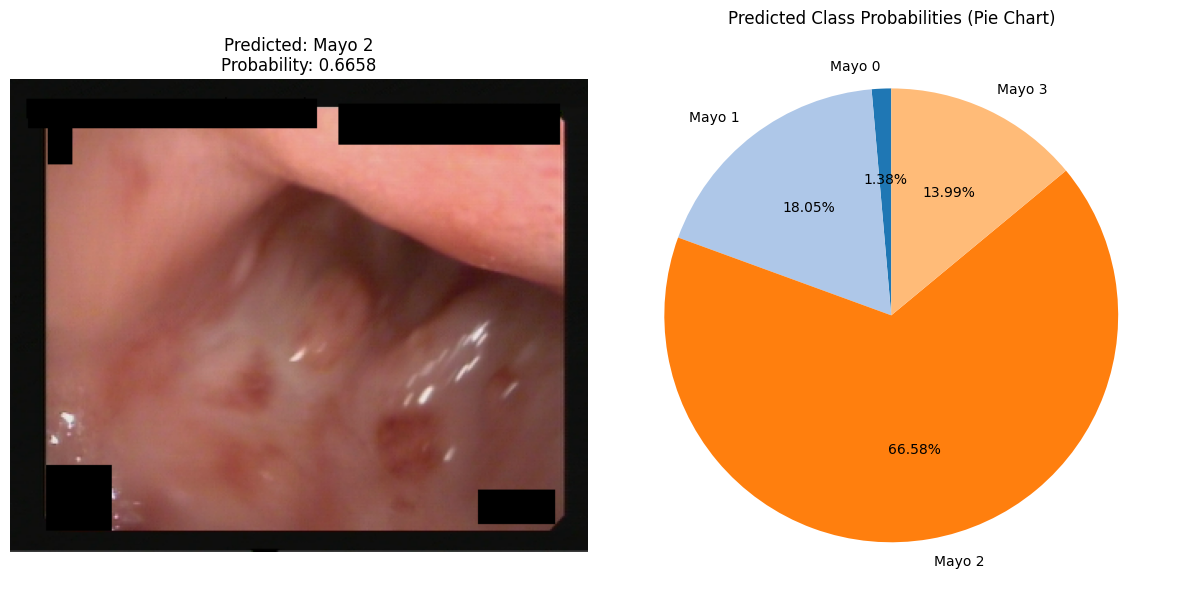

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, Reshape, Conv2D, Layer
from tensorflow.keras.utils import custom_object_scope
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import json

# Define Squeeze-and-Excitation Layer
class SqueezeExcitationLayer(Layer):
    def __init__(self, output_dim, ratio=16, **kwargs):
        super(SqueezeExcitationLayer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.ratio = ratio

    def build(self, input_shape):
        self.global_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(self.output_dim // self.ratio, activation='swish')
        self.dense2 = Dense(self.output_dim, activation='sigmoid')
        self.reshape = Reshape((1, 1, self.output_dim))
        self.multiply = Multiply()

    def call(self, inputs):
        x = self.global_pool(inputs)
        x = self.reshape(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.multiply([inputs, x])

    def get_config(self):
        config = super().get_config()
        config.update({"output_dim": self.output_dim, "ratio": self.ratio})
        return config

# Define Spatial Attention Layer
class SpatialAttentionLayer(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttentionLayer, self).__init__(**kwargs)
        self.conv1 = Conv2D(1, kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        return self.conv1(concat) * inputs

    def get_config(self):
        return super().get_config()

# Define paths and constants
img_path = '/content/drive/My Drive/LIMUC/test_set/Mayo 2/UC_patient_401_15.bmp'
model_paths = [f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{i + 1}.h5' for i in range(10)]
class_names = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
num_classes = len(class_names)

# Load saved class weights
weights_save_path = '/content/drive/My Drive/LIMUC/ensemble_class_weights.json'
with open(weights_save_path, 'r') as f:
    class_weights_per_model = json.load(f)

# Function to normalize predictions
def normalize_predictions(preds):
    return preds / np.sum(preds, axis=-1, keepdims=True)

# Load models with custom layers
models = []
with custom_object_scope({'SqueezeExcitationLayer': SqueezeExcitationLayer, 'SpatialAttentionLayer': SpatialAttentionLayer}):
    for path in model_paths:
        model = load_model(path, compile=False)
        models.append(model)

@tf.function(input_signature=[tf.TensorSpec(shape=(None, 380, 380, 3), dtype=tf.float32)])
def get_model_predictions(img_array):
    predictions = []
    for i, model in enumerate(models):
        model_preds = model(img_array, training=False)
        predictions.append(model_preds)
    return predictions

# Perform weighted ensemble prediction
def class_specific_weighted_ensemble_predict(models, class_weights_per_model, img_array):
    predictions = get_model_predictions(img_array)
    final_predictions = []

    for i, model_preds in enumerate(predictions):
        class_weights = np.array([class_weights_per_model[str(c)][i] for c in range(num_classes)])
        weighted_preds = model_preds.numpy() * class_weights[np.newaxis, :]
        final_predictions.append(weighted_preds)

    final_preds = np.sum(final_predictions, axis=0) / len(models)
    return normalize_predictions(final_preds)

# Preprocess single image
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(380, 380))
    img_array = img_to_array(img)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# Predict
img_array = preprocess_image(img_path)
ensemble_preds = class_specific_weighted_ensemble_predict(models, class_weights_per_model, img_array)

# Show normalized probabilities and predicted class
predicted_class = np.argmax(ensemble_preds)
print(f"Predicted Class: {predicted_class} ({class_names[predicted_class]})")
print(f"Normalized Class Probabilities: {ensemble_preds[0]}")

# Display image and all class probabilities as Pie Chart
def plot_image_with_probs_and_pie(img_path, preds, class_names):
    img = load_img(img_path)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display image
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title(f"Predicted: {class_names[np.argmax(preds)]}\nProbability: {preds[0][np.argmax(preds)]:.4f}")

    # Display pie chart for all class predictions
    class_probs = preds[0]
    axes[1].pie(class_probs, labels=class_names, autopct='%1.2f%%', startangle=90, colors=plt.cm.tab20.colors[:len(class_names)])
    axes[1].set_title('Predicted Class Probabilities (Pie Chart)')

    plt.tight_layout()
    plt.show()

plot_image_with_probs_and_pie(img_path, ensemble_preds, class_names)


Mounted at /content/drive
1/1 [==============================] - 3s 3s/step


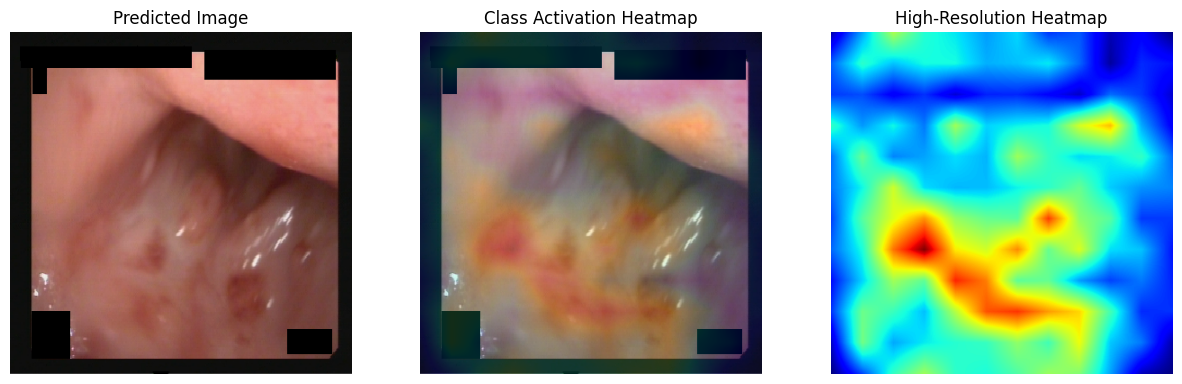

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, Reshape, Conv2D, Layer
from tensorflow.keras.utils import custom_object_scope
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import json
from PIL import Image
from scipy.ndimage import zoom


# Define Squeeze-and-Excitation Layer
class SqueezeExcitationLayer(Layer):
    def __init__(self, output_dim, ratio=16, **kwargs):
        super(SqueezeExcitationLayer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.ratio = ratio

    def build(self, input_shape):
        self.global_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(self.output_dim // self.ratio, activation='swish')
        self.dense2 = Dense(self.output_dim, activation='sigmoid')
        self.reshape = Reshape((1, 1, self.output_dim))
        self.multiply = Multiply()

    def call(self, inputs):
        x = self.global_pool(inputs)
        x = self.reshape(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.multiply([inputs, x])

    def get_config(self):
        config = super().get_config()
        config.update({"output_dim": self.output_dim, "ratio": self.ratio})
        return config

# Define Spatial Attention Layer
class SpatialAttentionLayer(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttentionLayer, self).__init__(**kwargs)
        self.conv1 = Conv2D(1, kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        return self.conv1(concat) * inputs

    def get_config(self):
        return super().get_config()

# Define paths and constants
img_path = '/content/drive/My Drive/LIMUC/test_set/Mayo 2/UC_patient_401_15.bmp'
model_paths = [f'/content/drive/My Drive/LIMUC/Temp2/CFCPL1103J_best_model_fold_{i + 1}.h5' for i in range(10)]
class_names = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
num_classes = len(class_names)

# Load saved class weights
weights_save_path = '/content/drive/My Drive/LIMUC/ensemble_class_weights.json'
with open(weights_save_path, 'r') as f:
    class_weights_per_model = json.load(f)

# Function to normalize predictions
def normalize_predictions(preds):
    return preds / np.sum(preds, axis=-1, keepdims=True)

# Load models with custom layers
models = []
with custom_object_scope({'SqueezeExcitationLayer': SqueezeExcitationLayer, 'SpatialAttentionLayer': SpatialAttentionLayer}):
    for path in model_paths:
        model = load_model(path, compile=False)
        models.append(model)

# Generate Grad-CAM heatmap
def get_feature_layer(model):
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 4:  # Last convolutional layer
            return layer.name
    raise ValueError("No 4D layer found")

def generate_cam(model, img_array, class_idx):
    feature_layer_name = get_feature_layer(model)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(feature_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Apply SmoothGrad
def apply_smoothgrad(generate_cam_fn, model, img_array, class_idx, num_samples=50, noise_level=0.1):
    smooth_heatmap = np.zeros_like(generate_cam_fn(model, img_array, class_idx))
    for _ in range(num_samples):
        noise = np.random.normal(0, noise_level, img_array.shape)
        noisy_img_array = img_array + noise
        heatmap = generate_cam_fn(model, noisy_img_array, class_idx)
        smooth_heatmap += heatmap
    smooth_heatmap /= num_samples
    return smooth_heatmap



# Display CAM and high-resolution heatmap with smoothing
def display_cam(heatmap, img_array, alpha=0.2):
    img = tf.keras.preprocessing.image.array_to_img(img_array[0])

    # Smooth the heatmap using interpolation
    heatmap = np.uint8(255 * heatmap)
    heatmap = zoom(heatmap, (img.size[1] / heatmap.shape[0], img.size[0] / heatmap.shape[1]), order=1)

    jet = plt.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize heatmap to match the original image size
    jet_heatmap = Image.fromarray((jet_heatmap * 255).astype(np.uint8))
    jet_heatmap = jet_heatmap.resize((img.size[0], img.size[1]), resample=Image.BICUBIC)
    jet_heatmap = np.array(jet_heatmap)

    # Superimpose heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img_array[0]
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Plot the results
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Predicted Image')
    plt.axis('off')

    # Superimposed Image
    plt.subplot(1, 3, 2)
    plt.imshow(superimposed_img)
    plt.title('Class Activation Heatmap')
    plt.axis('off')

    # Smooth Heatmap
    plt.subplot(1, 3, 3)
    plt.imshow(jet_heatmap.astype(np.uint8))
    plt.title('High-Resolution Heatmap')
    plt.axis('off')

    plt.show()



# Preprocess image and predict
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(380, 380))
    img_array = img_to_array(img)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# Predict
img_array = preprocess_image(img_path)
ensemble_preds = normalize_predictions(models[0].predict(img_array))
class_idx = np.argmax(ensemble_preds)

# Generate Grad-CAM heatmap
heatmap = generate_cam(models[0], img_array, class_idx)
smooth_heatmap = apply_smoothgrad(generate_cam, models[0], img_array, class_idx)

# Display results
display_cam(smooth_heatmap, img_array)
